# Importing Libraries 

In [10]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = all


import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics


#Learning curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve

# Loading Data

In [23]:
trainDF = pd.read_csv('data/cs-training.csv', index_col=0)
# trainDF.head(10)
# trainDF.info()
trainDF = trainDF.dropna()
#can drop NaN values
trainDF = trainDF.dropna()

#Can use this for cross-validation
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
# for train_index, test_index in cv.split(trainDF):
#     print("TRAIN:", train_index, "TEST:", test_index)

# Data Visualization

/home/sohail/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/sohail/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/home/sohail/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


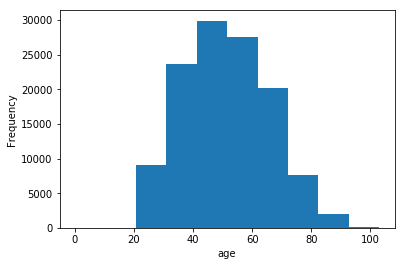

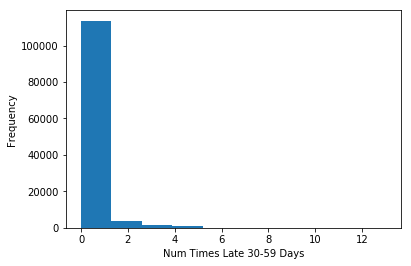

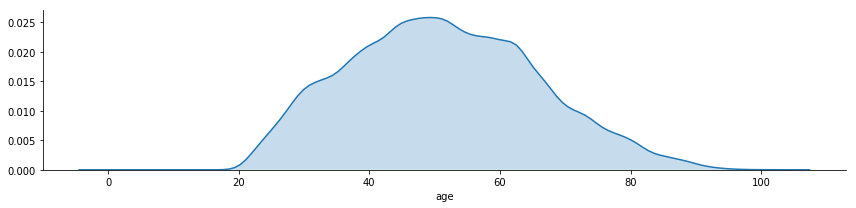

In [26]:
#Historam of Age
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1, 1) #1 rows, 1 column, 1st plot
ax2 = fig2.add_subplot(1,1, 1) #1 rows,1 column, 1st plot

n, bins, patches = ax1.hist(trainDF['age'])
ax1.set_xlabel('age')
ax1.set_ylabel('Frequency')
# fig1.savefig("hist_age.pdf", format='pdf')

trainDF.is_copy = False
trainDF['NumberOfTime30-59DaysPastDueNotWorse'].loc[(trainDF['NumberOfTime30-59DaysPastDueNotWorse']==98) 
    | (trainDF['NumberOfTime30-59DaysPastDueNotWorse']==96)] = trainDF['NumberOfTime30-59DaysPastDueNotWorse'].median()
#histogram of the NumberOfTime30-59DaysPastDueNotWorse
n, bins, patches = ax2.hist(trainDF['NumberOfTime30-59DaysPastDueNotWorse'])
ax2.set_xlabel('Num Times Late 30-59 Days')
ax2.set_ylabel('Frequency')
# fig2.savefig("hist_late.pdf", format='pdf')


#can also visualize data with KDE plot
#similar to histogram in that it treats each data point as Gaussian distribution
#and then takes cumulative probability function

# Set the figure equal to a facetgrid with the training set as data and change the aspect ratio
fig = sns.FacetGrid(trainDF, aspect=4)
# Next use map to plot all the possible kdeplots for the 'age' values
sns_plot = fig.map(sns.kdeplot,'age',shade= True)

# Data cleaning and more visualization

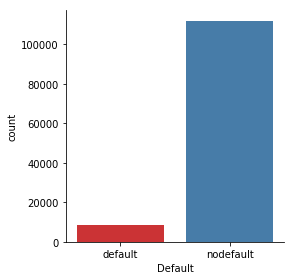

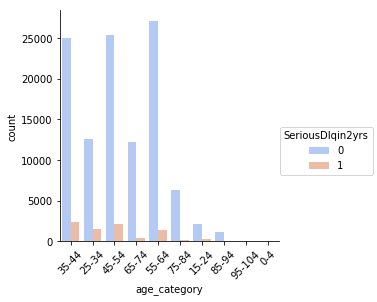

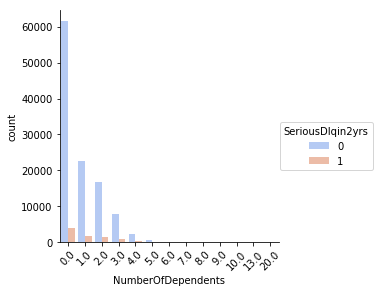

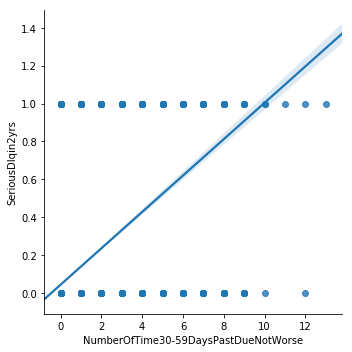

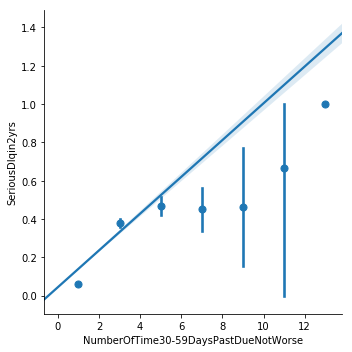

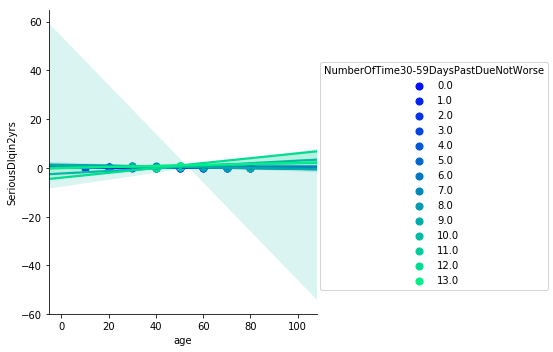

In [40]:
#see defaults vs nondefaults by creating new column called 'Default'
trainDF['Default'] = trainDF.SeriousDlqin2yrs.map({0:'nodefault', 1:'default'})
#truncate the age into nearest 10, 20, 30, 40 ...
trainDF['age_rounded'] = np.round(trainDF['age'],-1)
#categorize ages 0-5, 5-15, 15-25, ...
categories_dict = {0 : '0-4', 10 : '5-14', 20 : '15-24', 30: '25-34', 40: '35-44',
                    50 : '45-54',60 : '55-64', 70 : '65-74', 80 : '75-84',
          90 : '85-94',100 : '95-104', 110 : '105+'}
trainDF['age_category'] = trainDF['age_rounded'].map(categories_dict)

#Plot defaults
defaultplot = sns.factorplot('Default', data=trainDF, kind="count", palette='Set1')
# defaultplot.savefig("default.pdf",format="pdf")

#defaults vs age
defaultplot = sns.factorplot('age_category', data=trainDF, hue='SeriousDlqin2yrs',kind="count",palette='coolwarm')
defaultplot.set_xticklabels(rotation=45)
defaultplot.savefig("default_age.pdf",format="pdf")

#defaults vs # of dependents
defaultplot = sns.factorplot('NumberOfDependents', data=trainDF, hue='SeriousDlqin2yrs',kind="count",palette='coolwarm')
defaultplot.set_xticklabels(rotation=45)
# defaultplot.savefig("default_dependents.pdf",format="pdf")

#try to see if number of times borrower was 30-59days late in payment
#affected whether they defaulted or not
times=[1,3,5,7,9,11,13]
sns_plot=sns.lmplot('NumberOfTime30-59DaysPastDueNotWorse','SeriousDlqin2yrs',data=trainDF)
# sns_plot.savefig("late.pdf", format='pdf')
sns_plot=sns.lmplot('NumberOfTime30-59DaysPastDueNotWorse','SeriousDlqin2yrs',data=trainDF,palette='winter',x_bins=times)
# sns_plot.savefig("late_bins.pdf", format='pdf')

# # #can visualize this with linear plot
generations=[10,20,30,40,50,60,70, 80]
sns_plot =sns.lmplot('age','SeriousDlqin2yrs',hue='NumberOfTime30-59DaysPastDueNotWorse',data=trainDF,palette='winter',x_bins=generations)
# sns_plot.savefig("late_age_linear.pdf", format='pdf')